In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
work_dir="../datasets/tcga/BRCA/mirna_allsamples/"
#working_dir="../cancers/breast/"
os.chdir(work_dir)

## Survival

In [3]:
df_files = pd.read_csv("files.dat", sep=",")
df_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 26 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   cases.0.submitter_id                                               780 non-null    object 
 1   cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id.1  780 non-null    object 
 2   level_0                                                            780 non-null    object 
 3   index                                                              780 non-null    object 
 4   cases.0.demographic.days_to_birth                                  769 non-null    float64
 5   cases.0.demographic.days_to_death                                  108 non-null    float64
 6   cases.0.demographic.gender                                         779 non-null    object 
 7   cases.0.demographic.vital_

In [4]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].mean(skipna=True)
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

In [5]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

In [6]:
for letter in ["a", "b", "c"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage ii', 'stage iii', 'stage i', 'stage x', 'not reported',
       'stage iv', nan], dtype=object)

In [7]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v", "stage x"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

In [8]:
#0 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

In [9]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

In [10]:
import lifelines
import sys
sys.path.append("/home/jovyan/work/phd/")
from survival import fit_cox, add_group_to_subset, save_plot
from topicpy.hsbmpy import get_file

In [56]:
l=1

algorithm = "trisbm"
kind = "keyword", "metadatum"
#kind = "word", "topic"

In [43]:
df_clusters = pd.read_csv("trisbm/trisbm_level_1_%s-dist.csv"%kind[1],index_col=1).drop("i_doc",1)

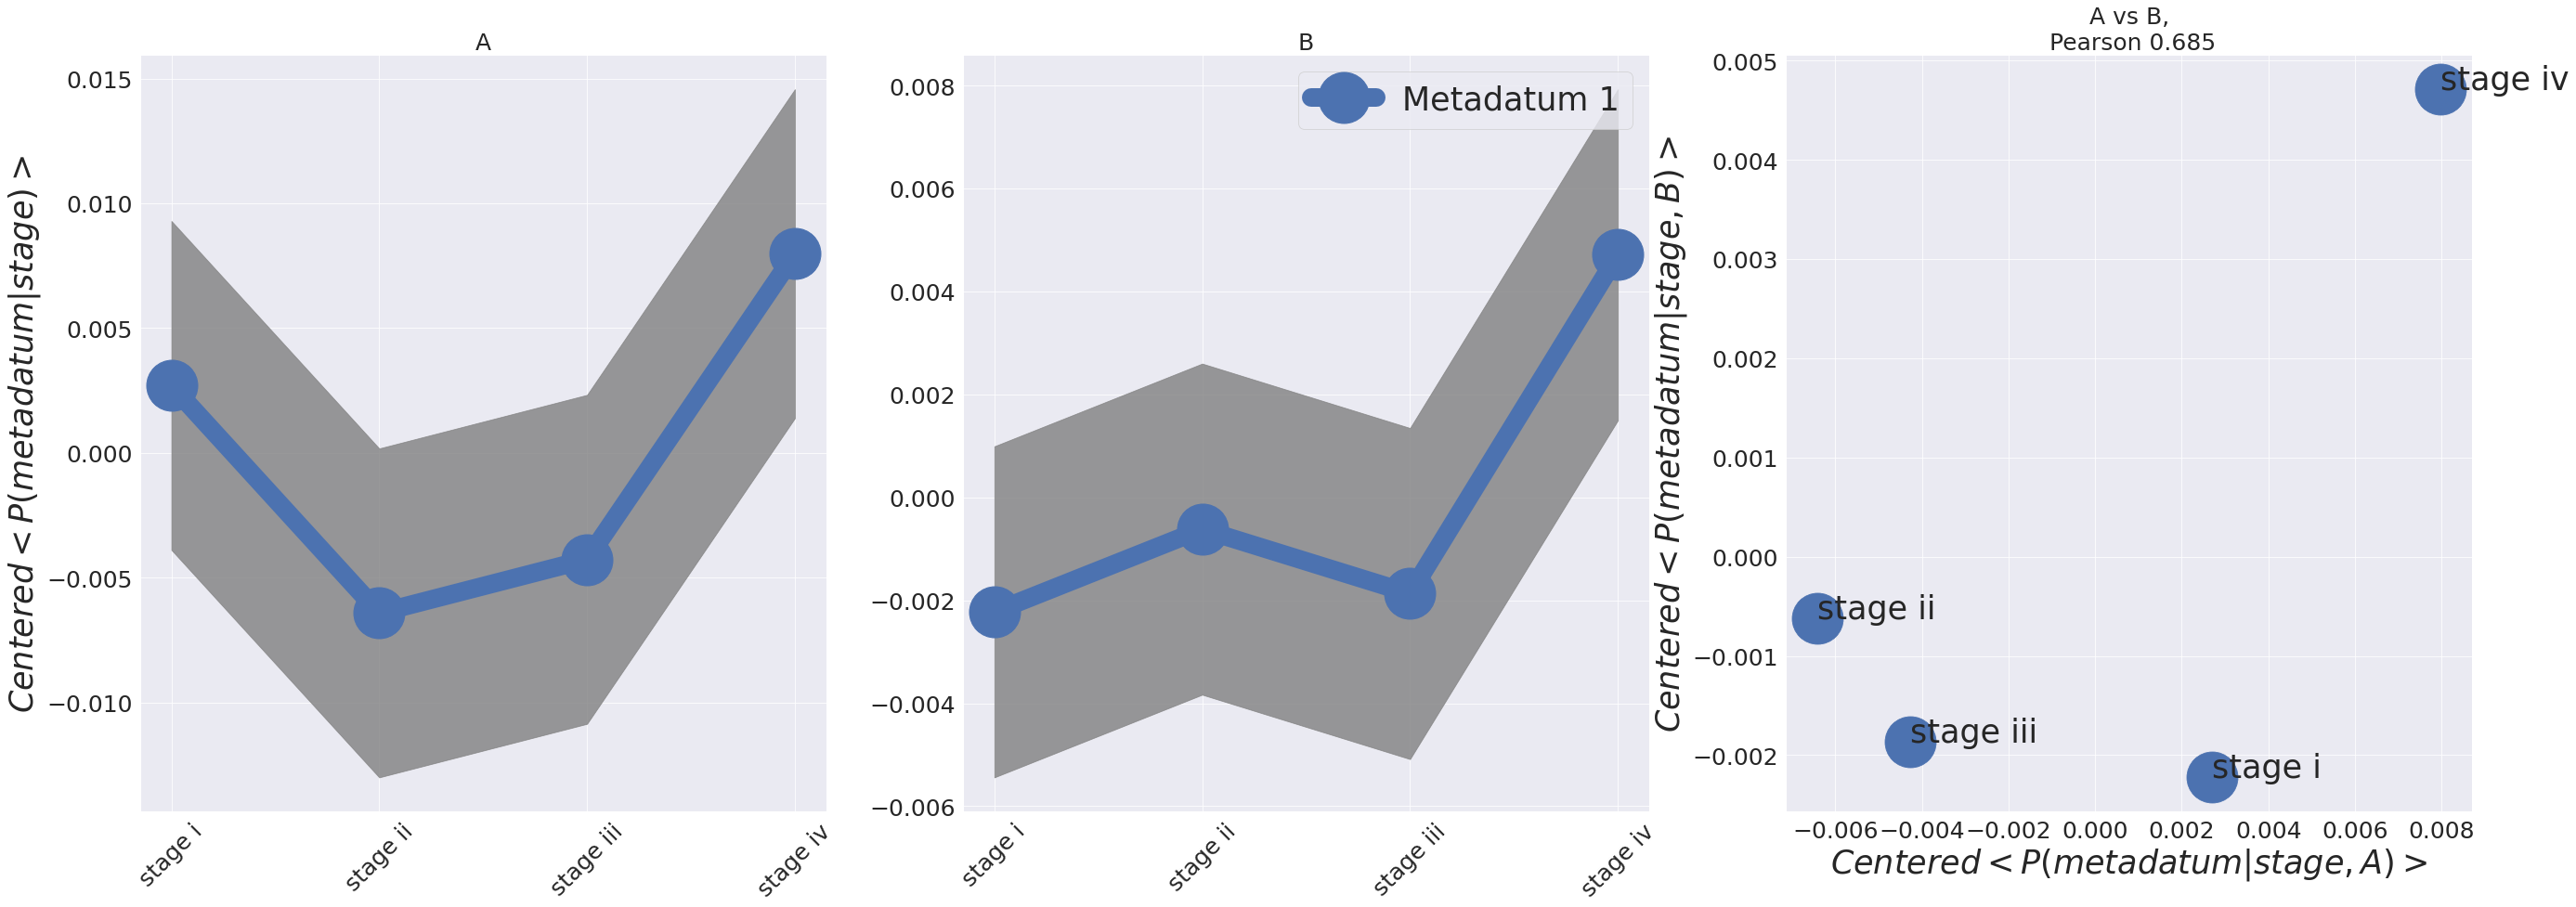

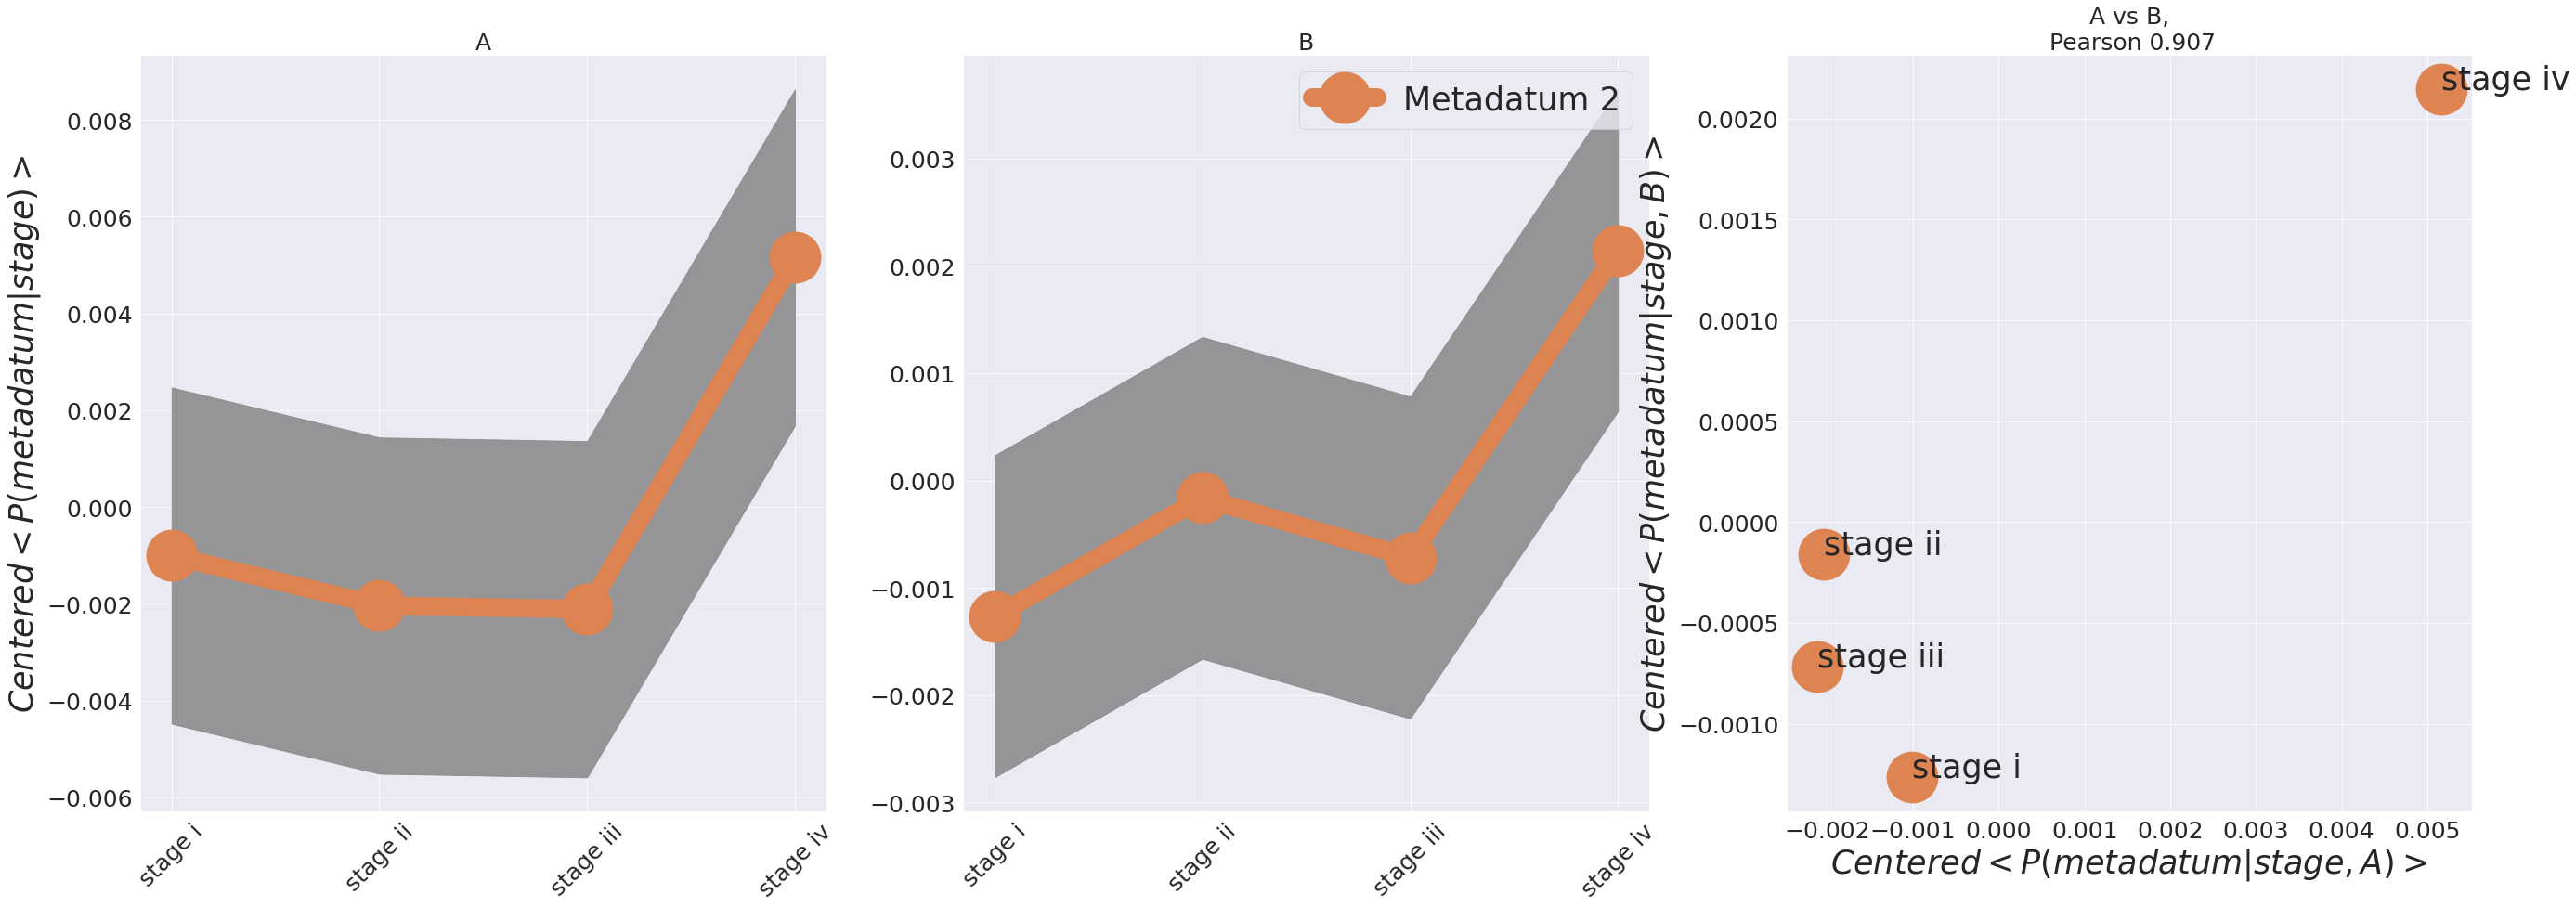

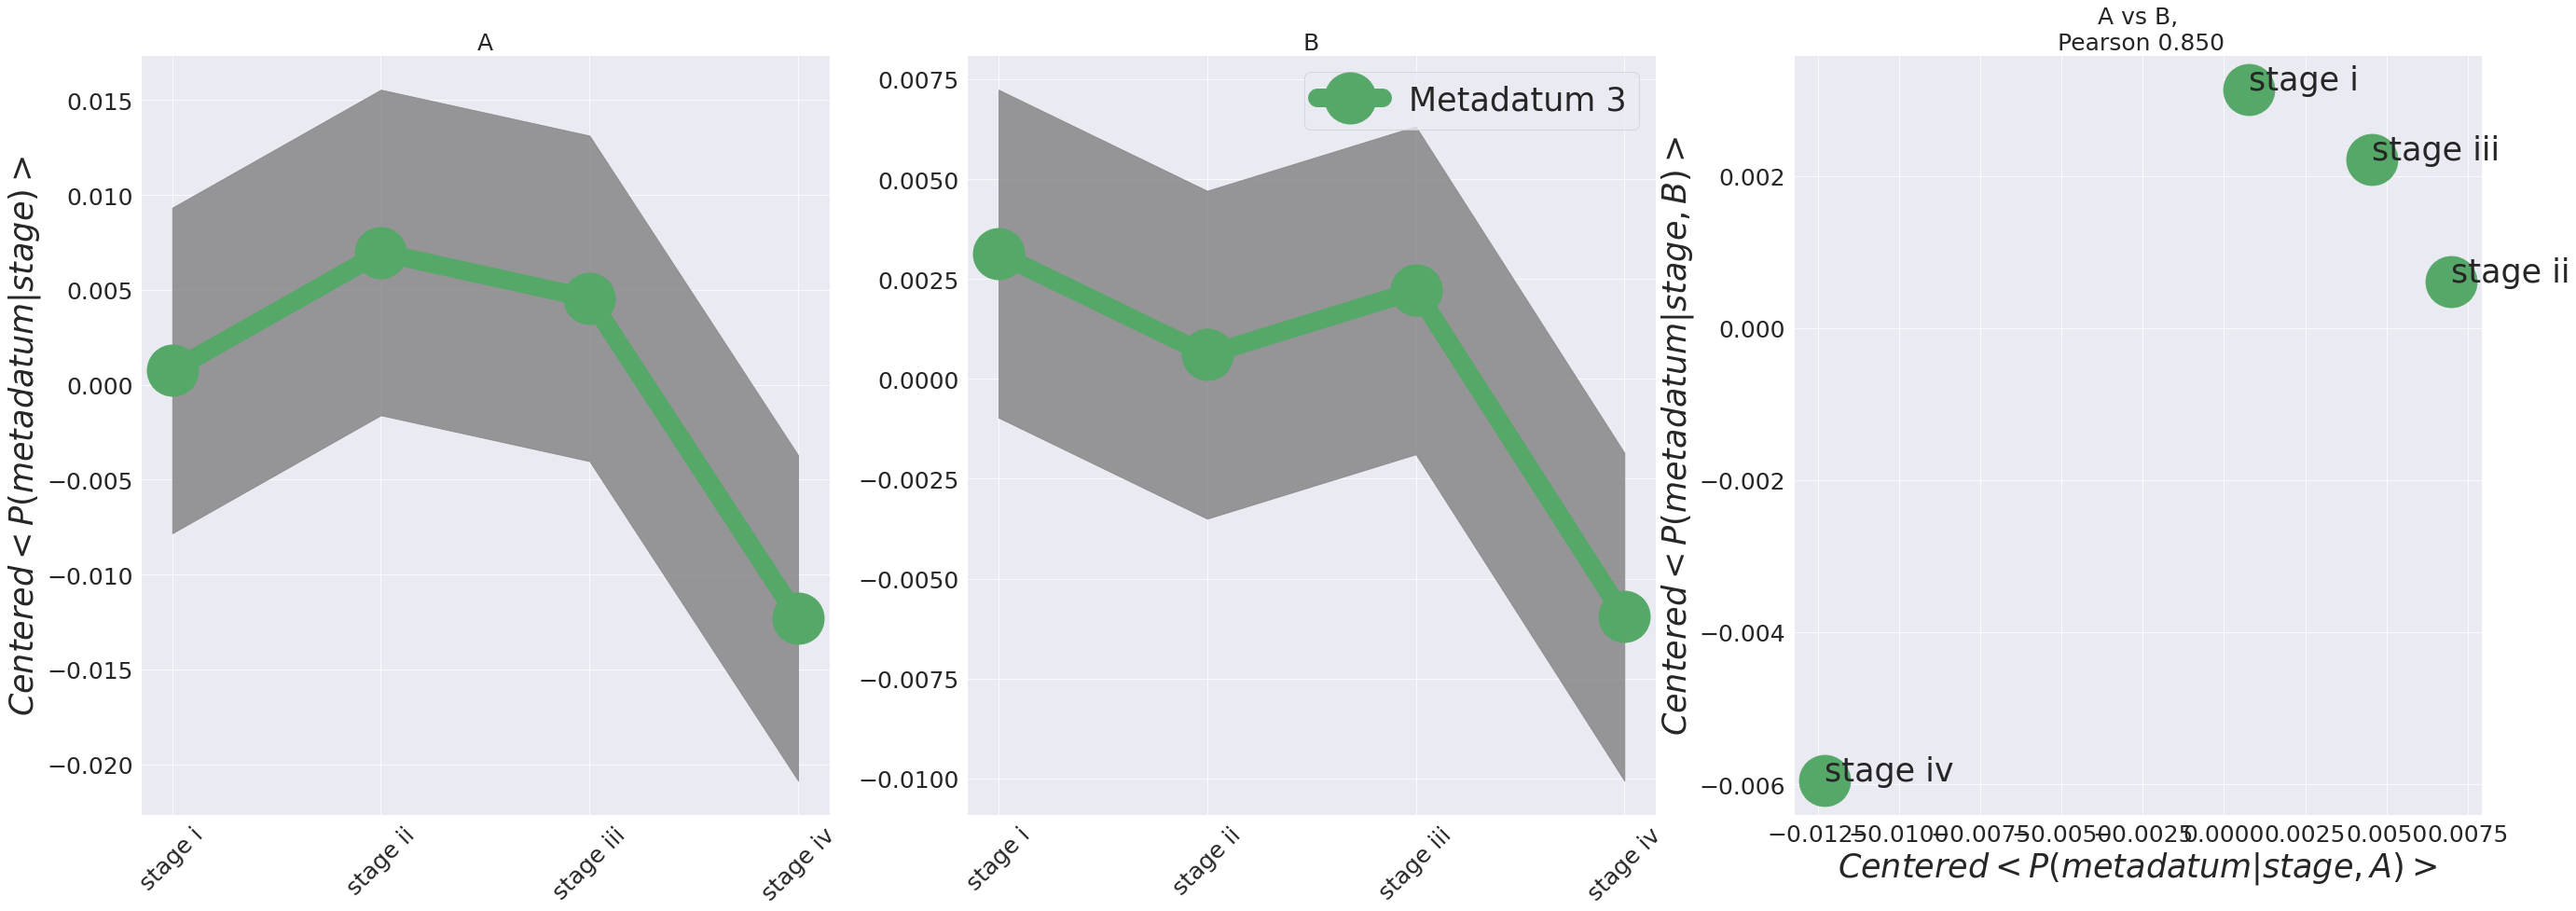

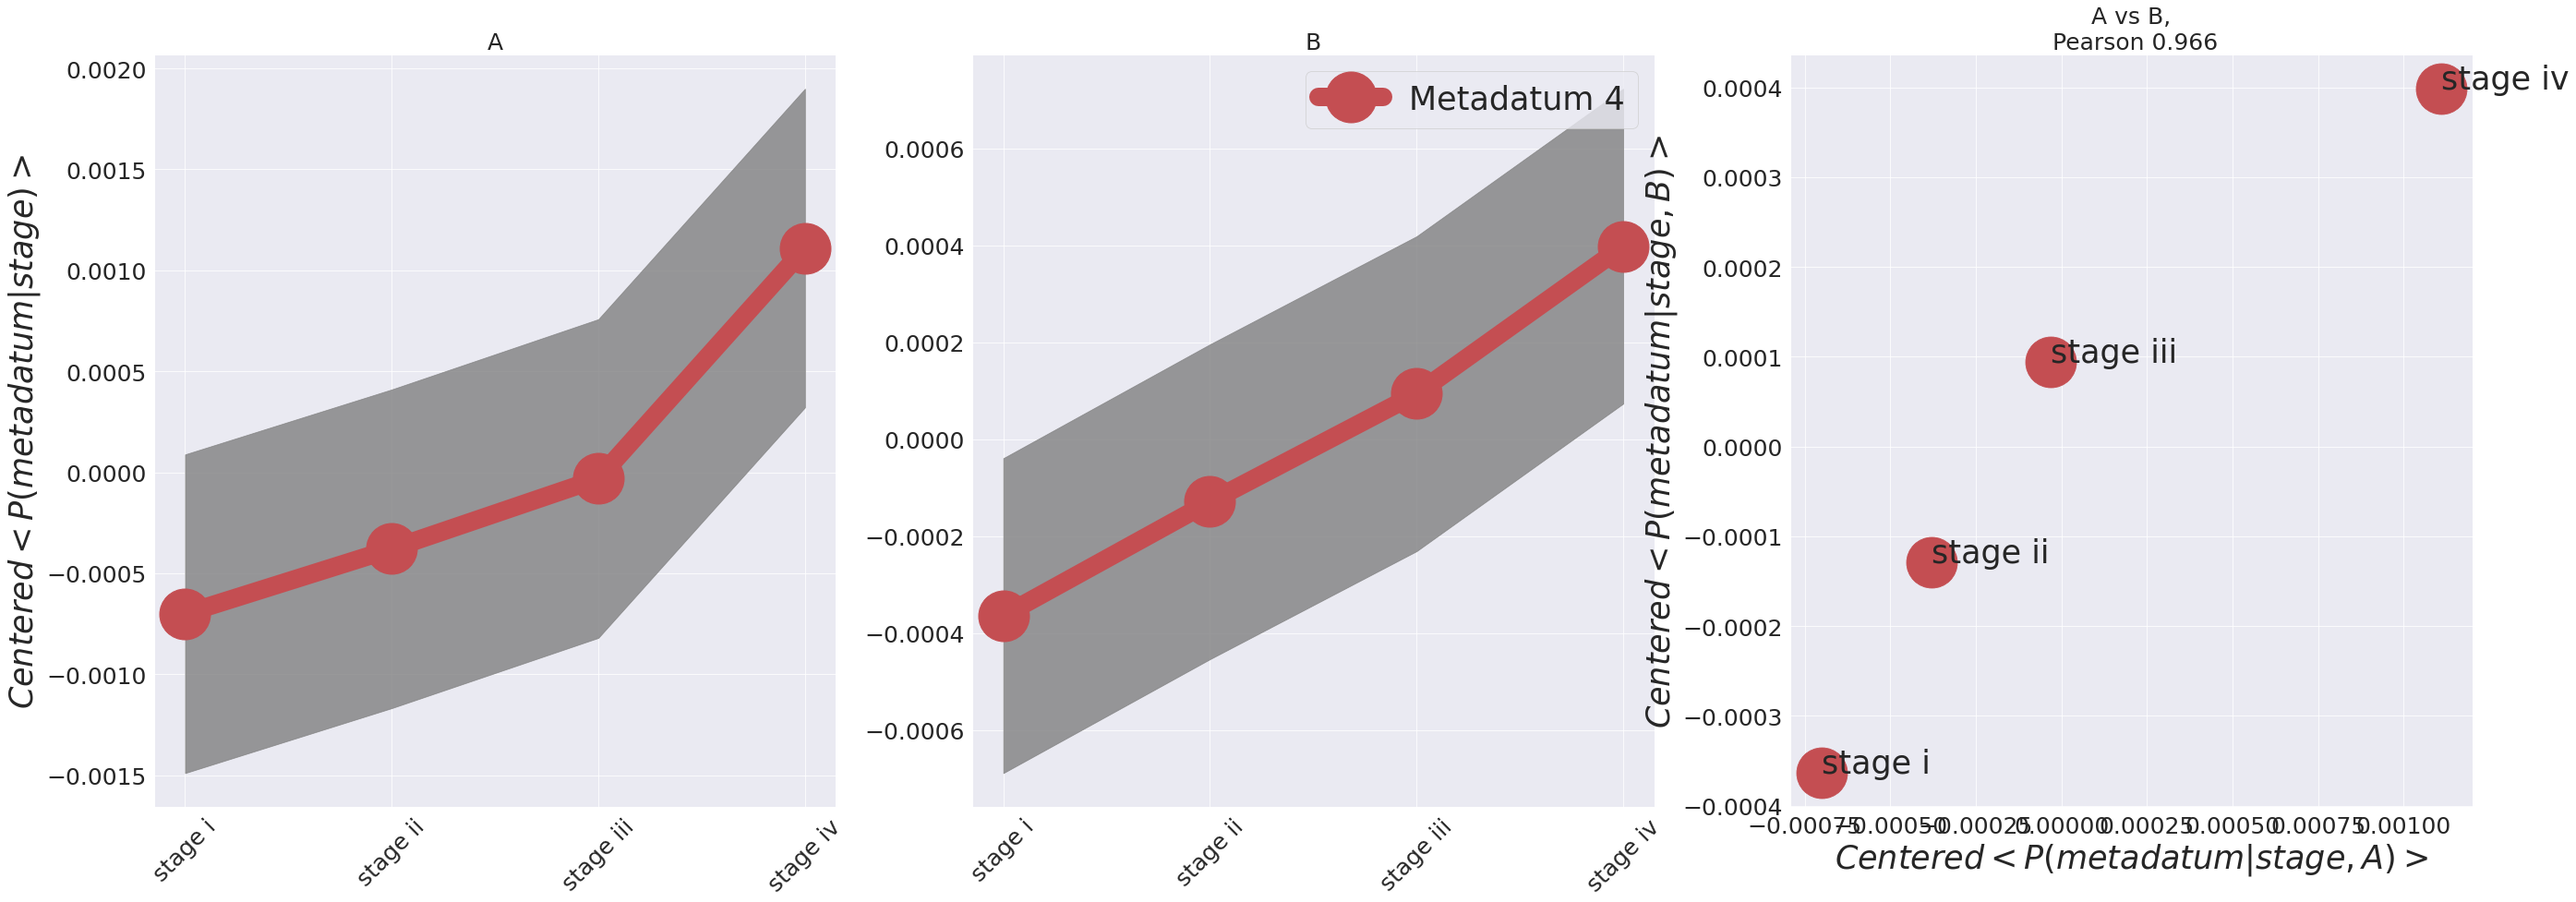

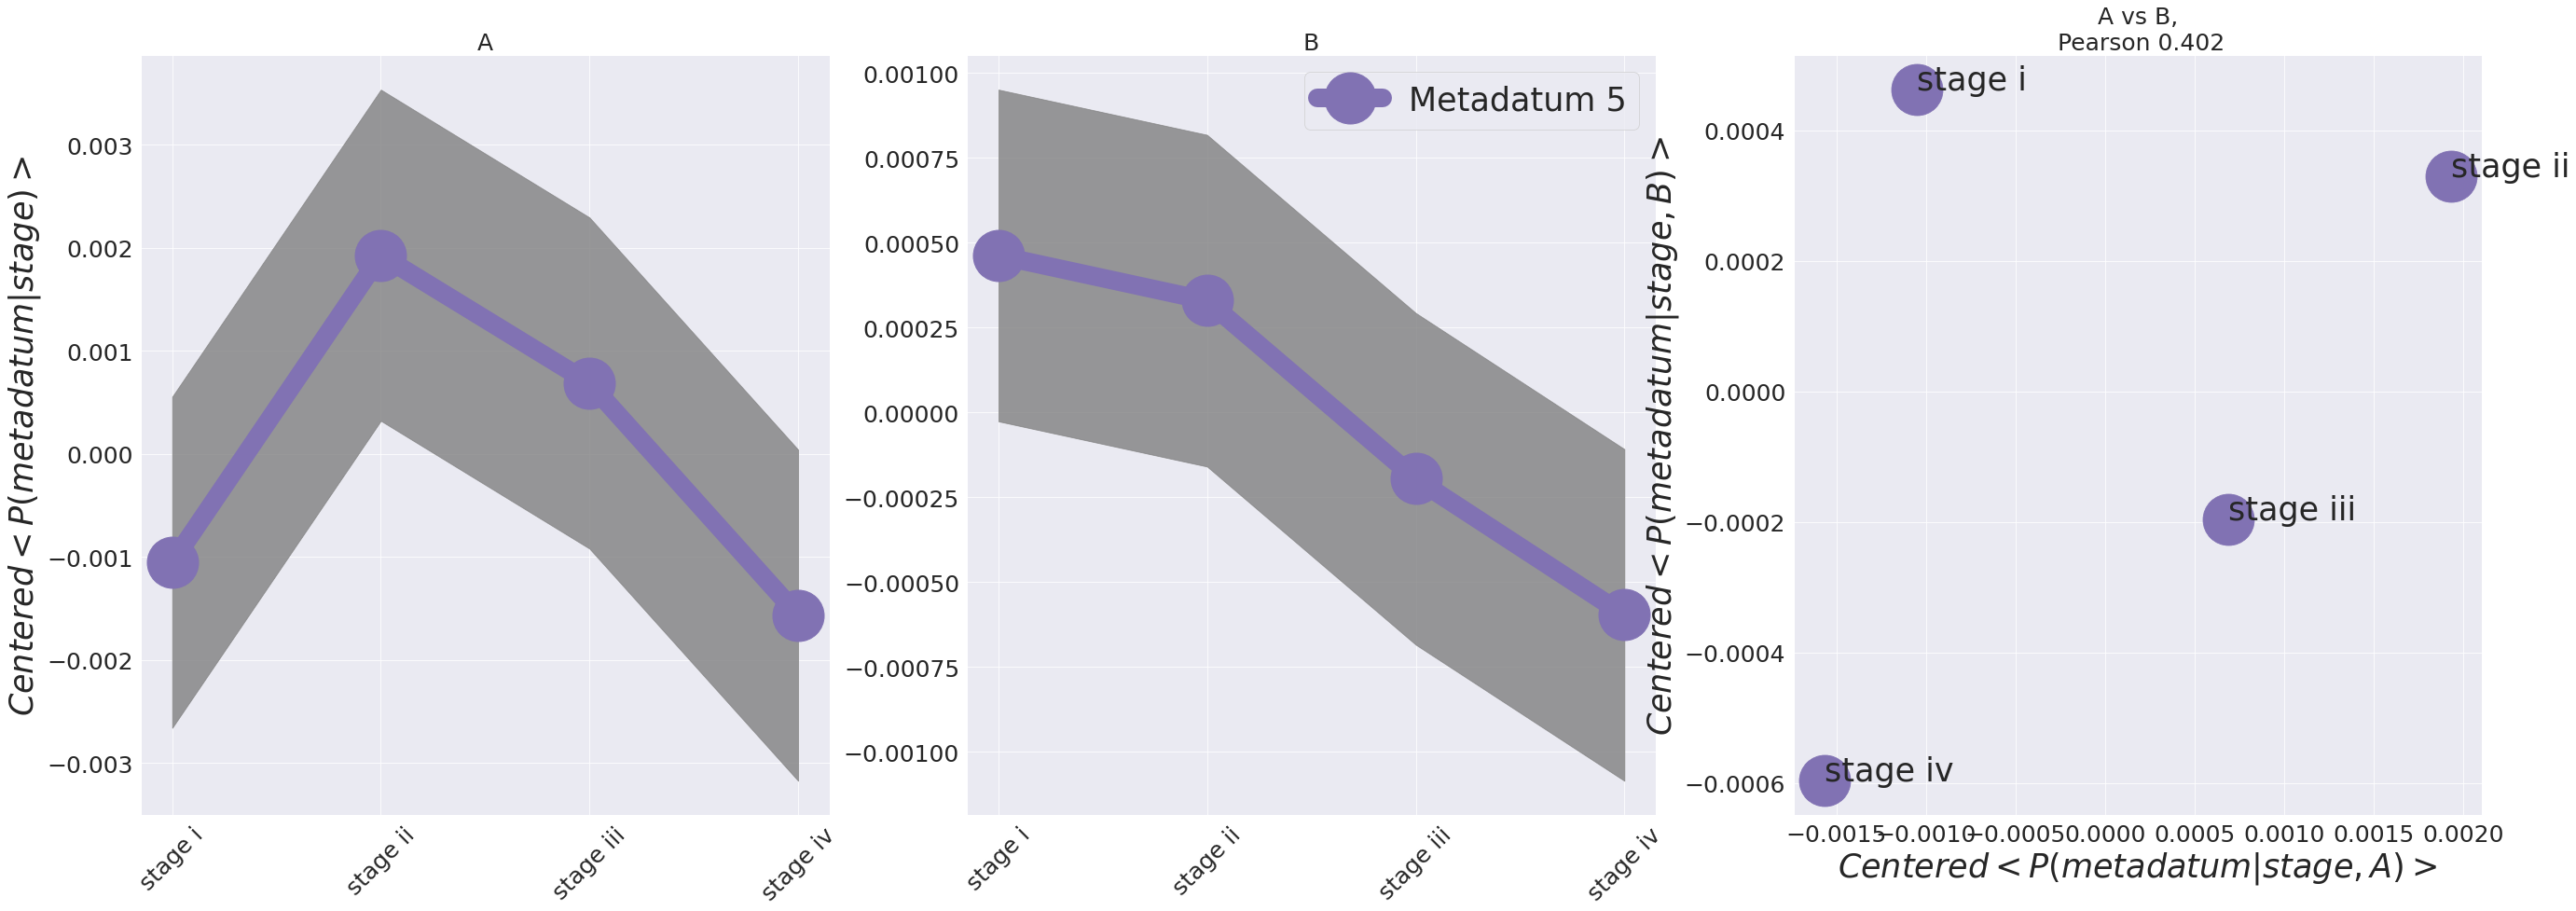

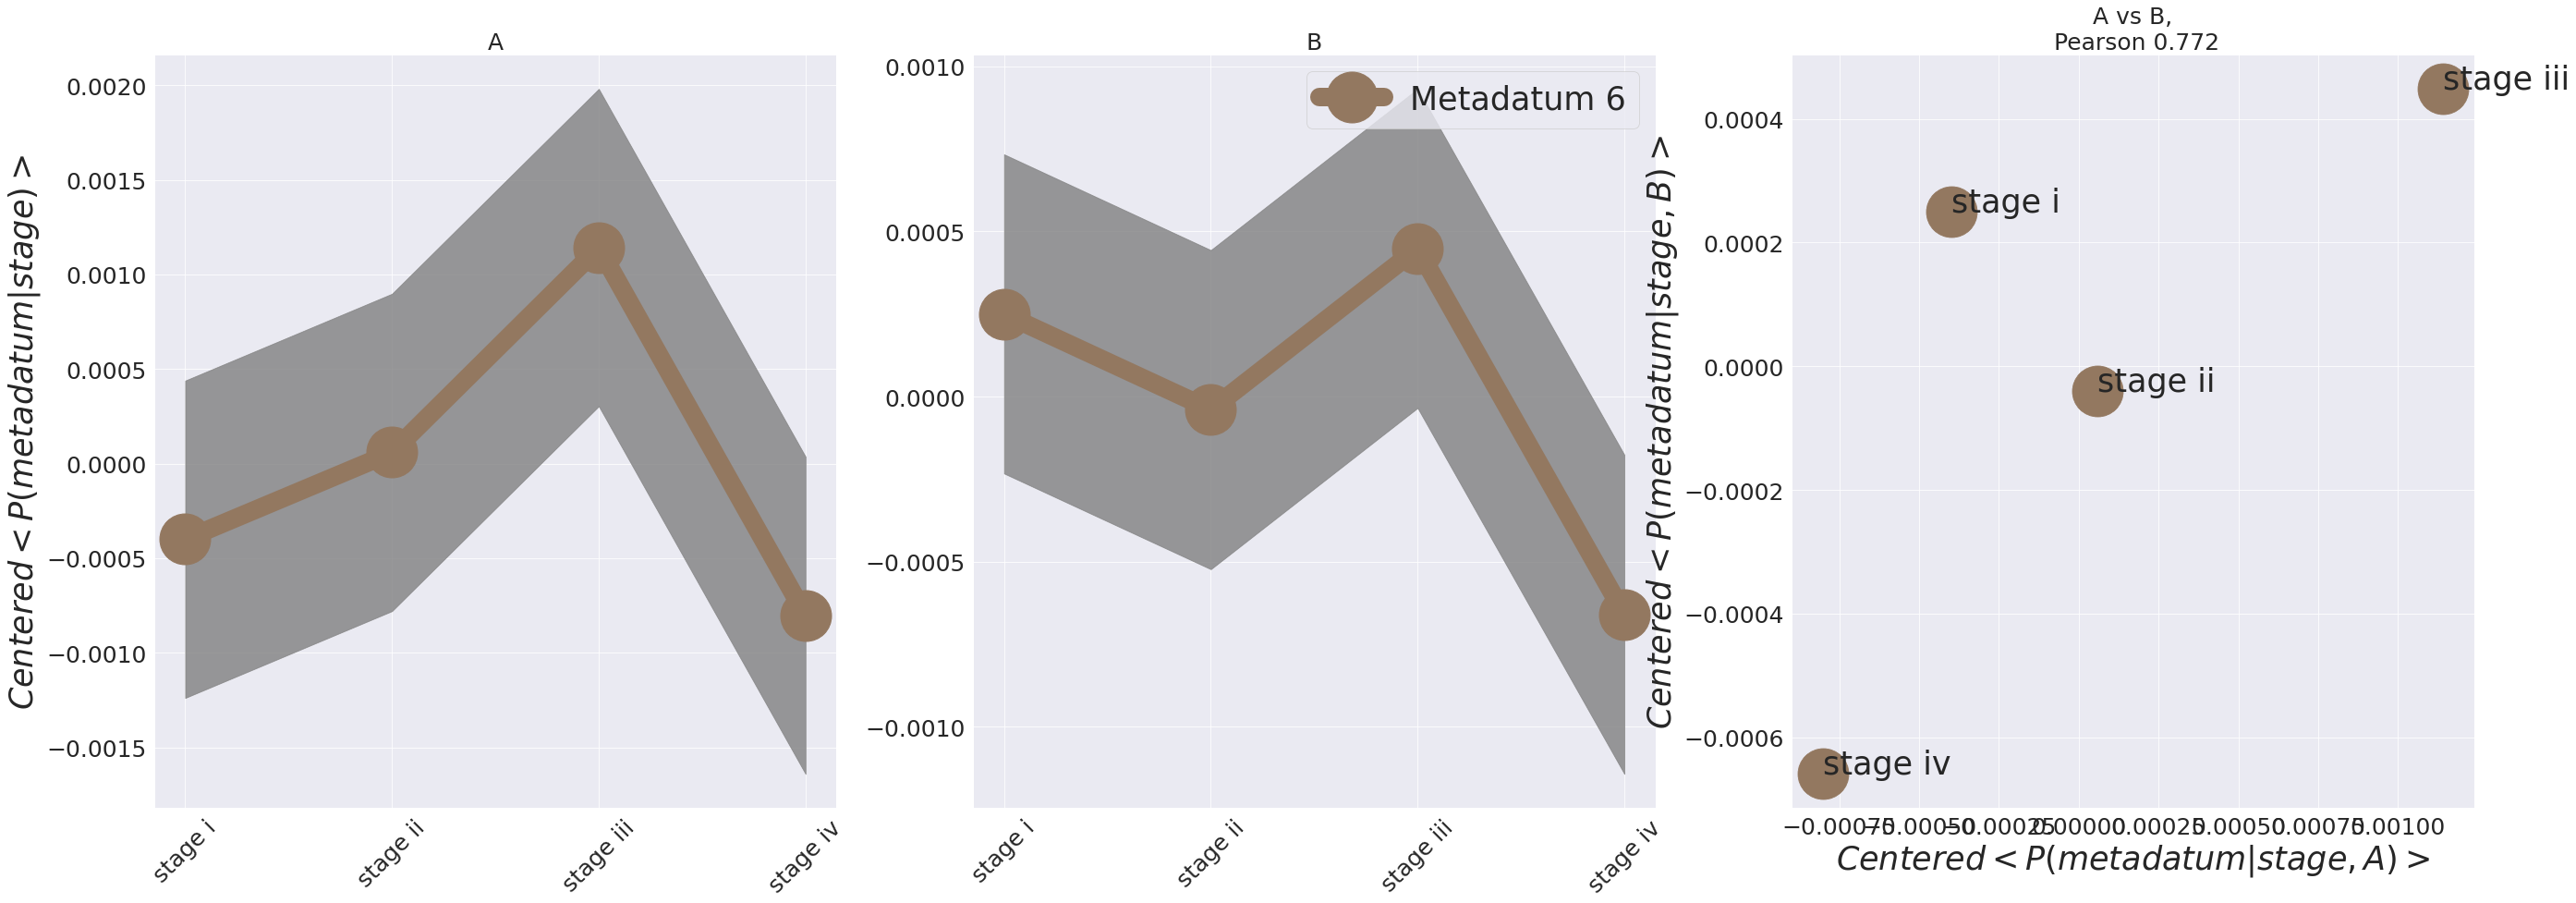

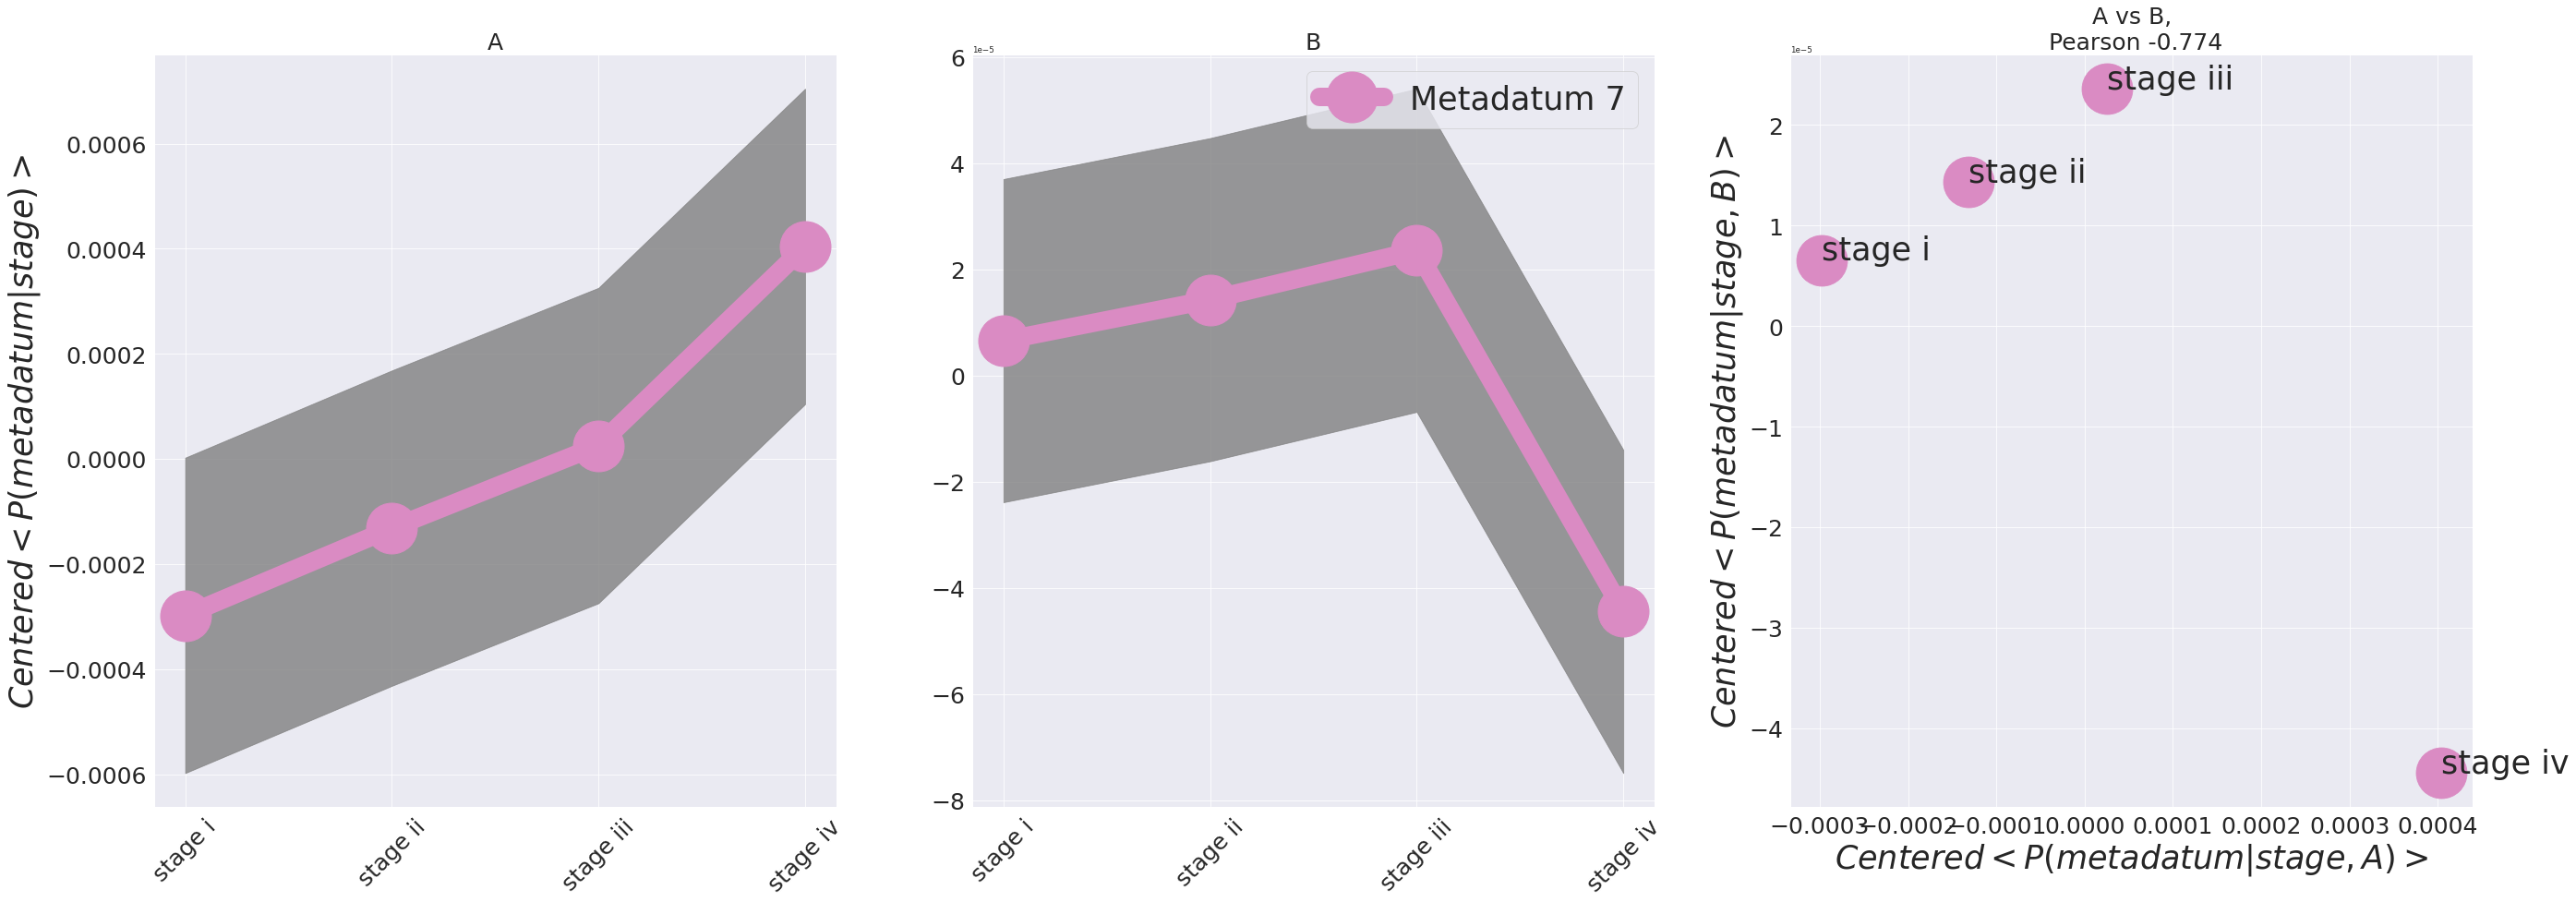

In [49]:
df_topics = pd.read_csv("%s/%s_level_%d_%s-dist.csv"%(algorithm,algorithm,l,kind[1]))
df_metadata = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
for letter in ["a", "b", "c"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_metadata.replace(old, new, inplace=True)

df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'stage','')
df_topics.insert(0,'cohort','')
df_topics.drop('i_doc', axis=1, inplace=True)

labels=["cases.0.diagnoses.0.tumor_stage","Subtype_Selected"]
label = labels[0]

if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
for sample in df_topics.index.values:
    file_data = get_file(sample,df_metadata)
    if file_data is None:
        continue
    if (file_data[labels[1]]=="BRCA.Basal"):
        name = "A"
    else:
        name = "B"
    df_topics.at[sample,'stage']=("%s"%(file_data[labels[0]]))
    df_topics.at[sample,'cohort']=("%s"%(name))

mask = df_topics["stage"]!="not reported"
mask = (mask) & (df_topics["stage"]!="")
mask = (mask) & (df_topics["stage"]!="stage x")
mask = (mask) & (df_topics["stage"]!="nan")
df_topic_stage_gb = df_topics[mask].groupby(["cohort", "stage"])

df_topic_stage = df_topics[mask]

color_generator=(c for c in sns.palettes.color_palette(n_colors=20, palette=None))
df_topic_stage = df_topic_stage_gb.mean()

for topic in df_topic_stage.columns:
    fig, axs = plt.subplots(1,3,figsize=(45,15))
    color = next(color_generator)
    X = []
    for ((i,dataset), ax) in zip(enumerate(np.unique([idx[0] for idx in df_topic_stage.index])), axs[:2]):
        idxs = int(round(df_topic_stage.index.shape[0]/2))
        idx = df_topic_stage.index[i*idxs:(i+1)*idxs]
        
        df_topic_stage_dat = df_topic_stage.reindex(index=idx, columns = [topic])
        mean = df_topic_stage_dat.mean(0).values
        df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
        #sigma = df_topic_stage_dat.std(0).values[0]
        #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
        df_topic_stage_dat.plot(ax=ax, marker="o",ms=55, lw=20, c=color, legend=False)
        
        x = ax.lines[0].get_xdata()
        y = ax.lines[0].get_ydata()
        err = (df_topic_stage_dat.std(0)).values.ravel()
        ax.fill_between(ax.lines[0].get_xdata(), y-err, y+err, color="gray", alpha=0.8)
        
        
        labs = np.sort(df_topics[mask]["stage"].unique())
        ax.set_xticks(x)
        ax.set_xticklabels(labels=labs, rotation=45)
        ax.tick_params(labelsize=25)
        ax.set_title(dataset, fontsize=25)
        ax.set_xlabel("")
        
        X.append(y)
        
    axs[1].legend(fontsize=35, ncol=3)
    axs[0].set_ylabel("$Centered <P(%s|stage)>$"%kind[1], fontsize=35)
    
    ax = axs[2]
    ax.scatter(*X, s=55**2, color=color)
    for x,y, text in zip(X[0],X[1],["stage i","stage ii","stage iii","stage iv"]):
        ax.annotate(text, (x,y), size=35)
    ax.tick_params(labelsize=25)
    ax.set_title("A vs B,\n Pearson {:.3f}".format(pearsonr(X[0],X[1])[0]), fontsize=25)
    ax.set_xlabel("")
    ax.set_xlabel("$Centered <P(%s|stage,A)>$"%kind[1], fontsize=35)
    ax.set_ylabel("$Centered <P(%s|stage,B)>$"%kind[1], fontsize=35)
    ax.ticklabel_format(style="sci", useOffset=True)

    fig.savefig(f"{kind[1]}_A_B_{topic}.pdf")
    

    plt.show()

In [50]:
from scipy.stats import pearsonr

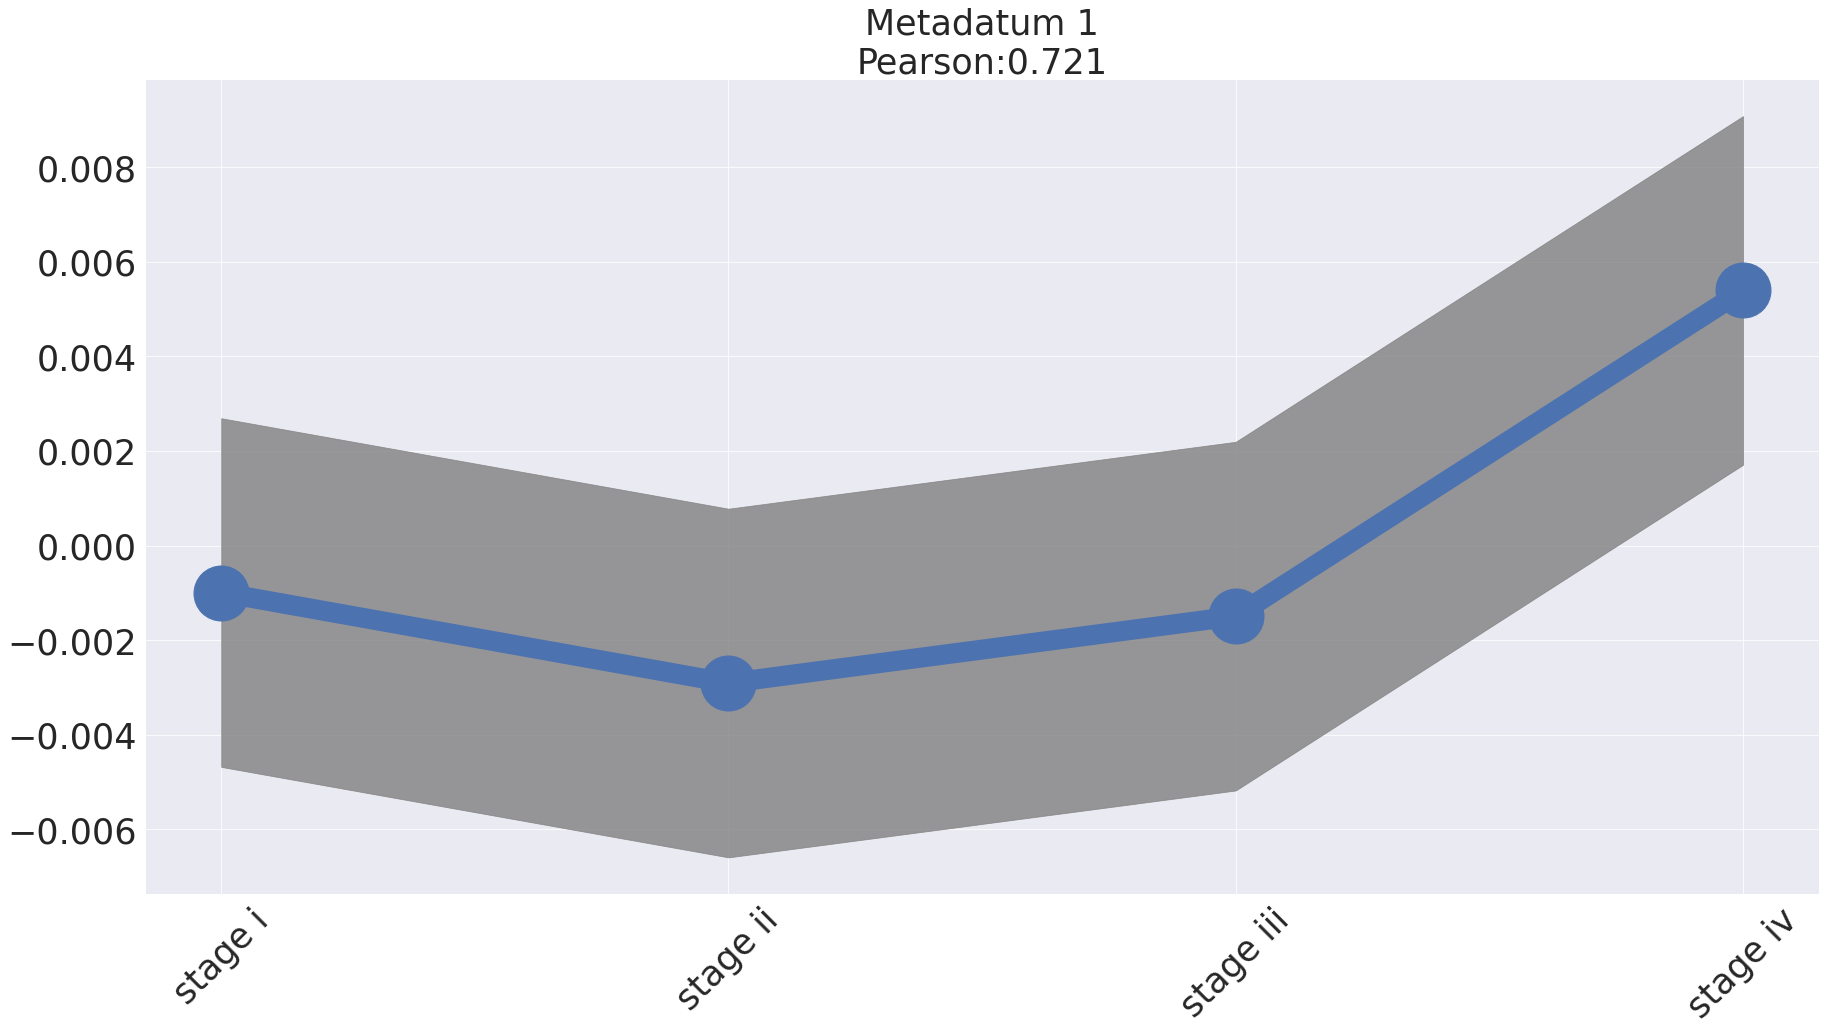

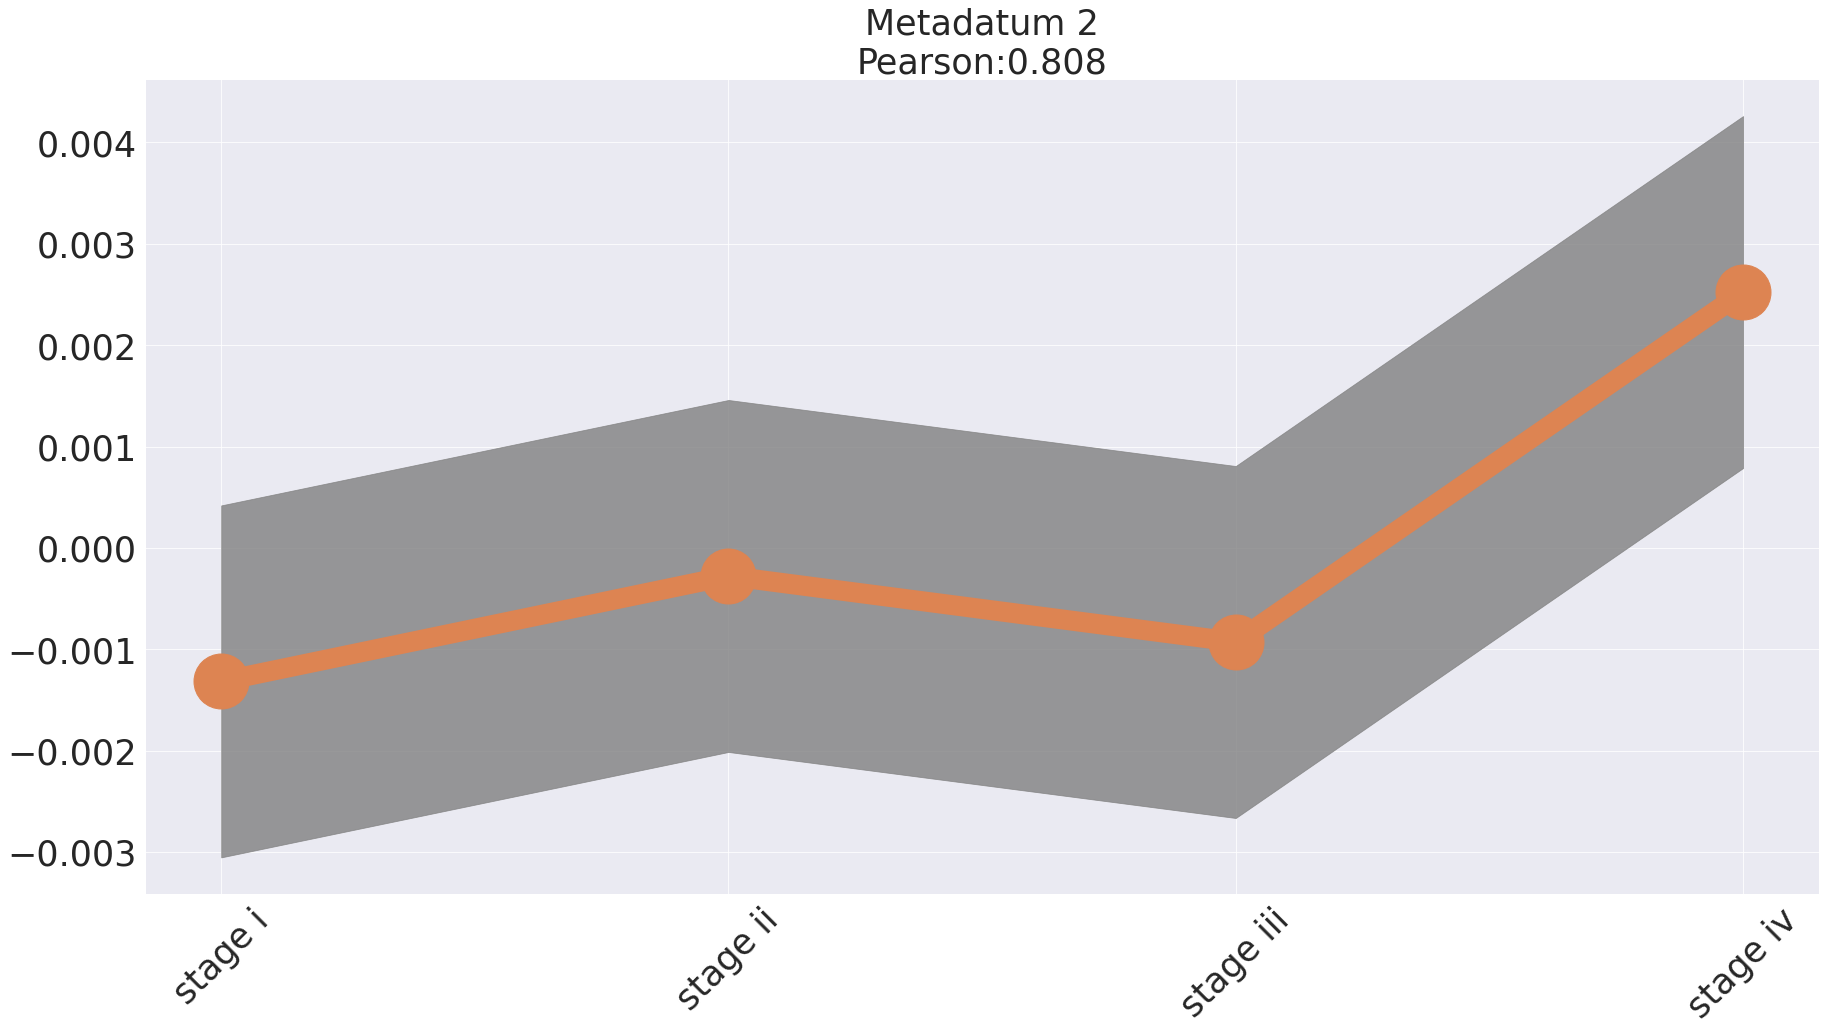

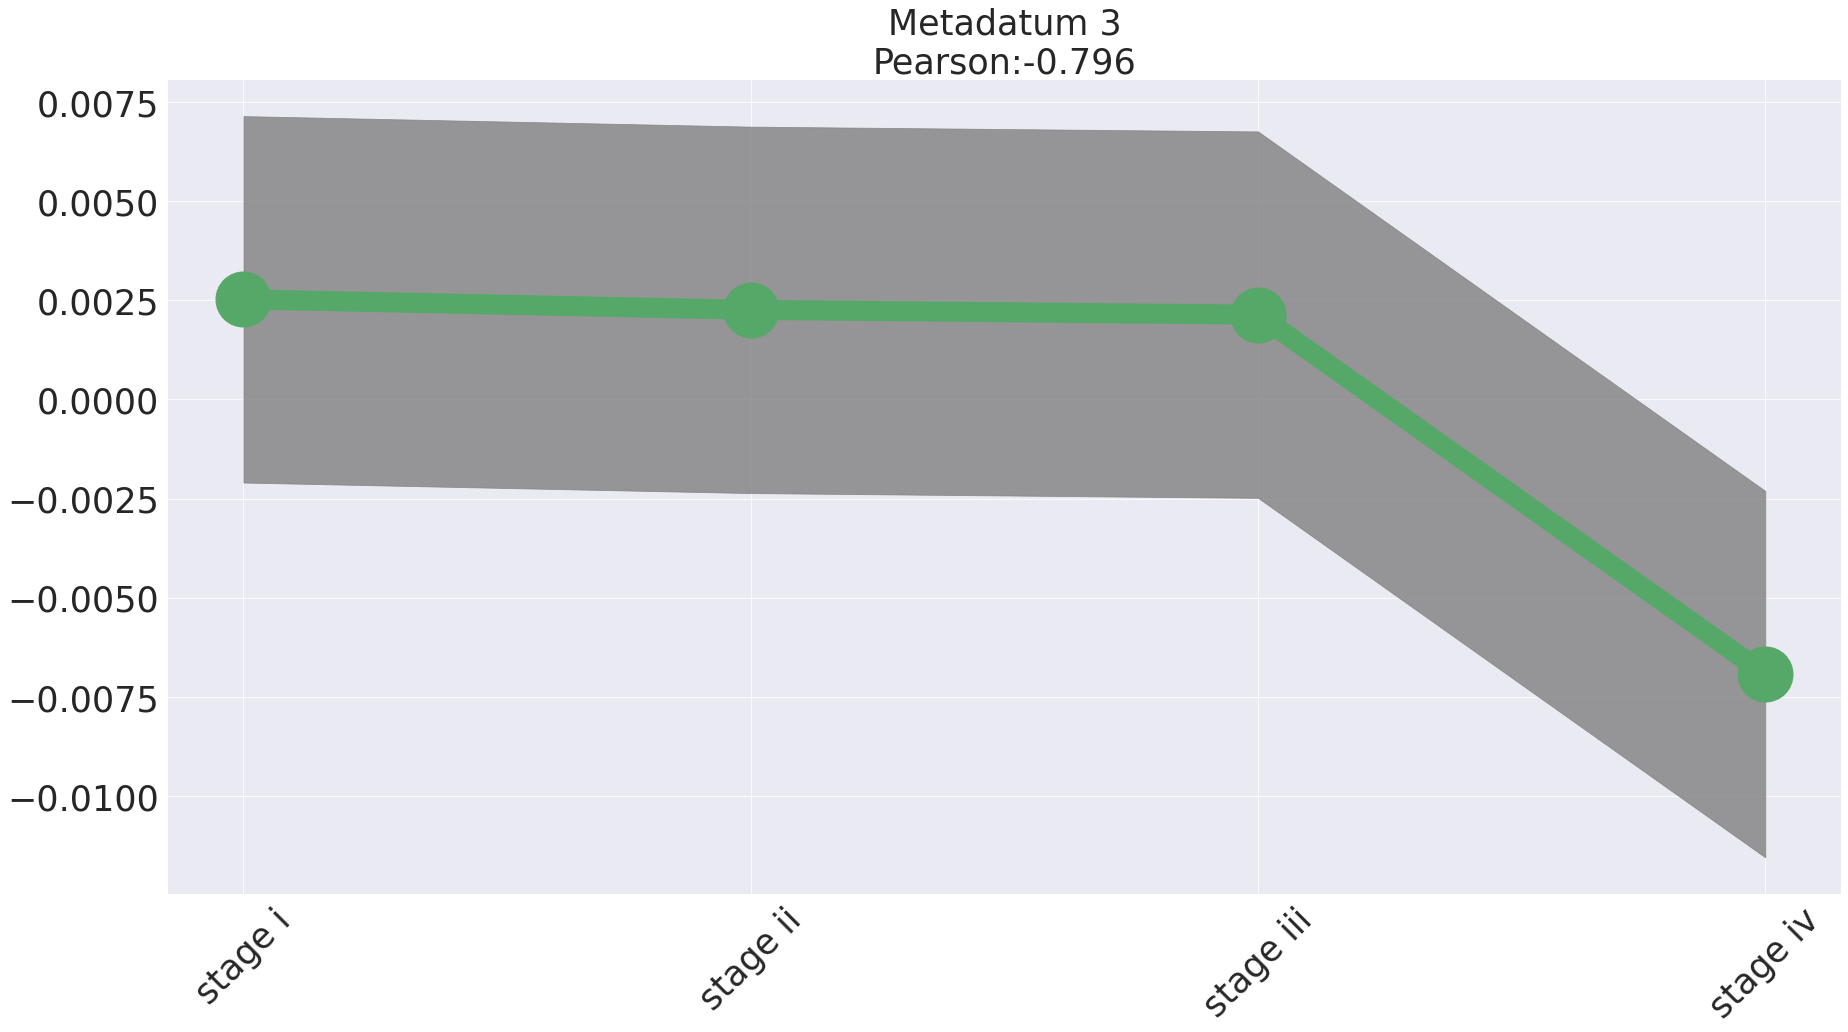

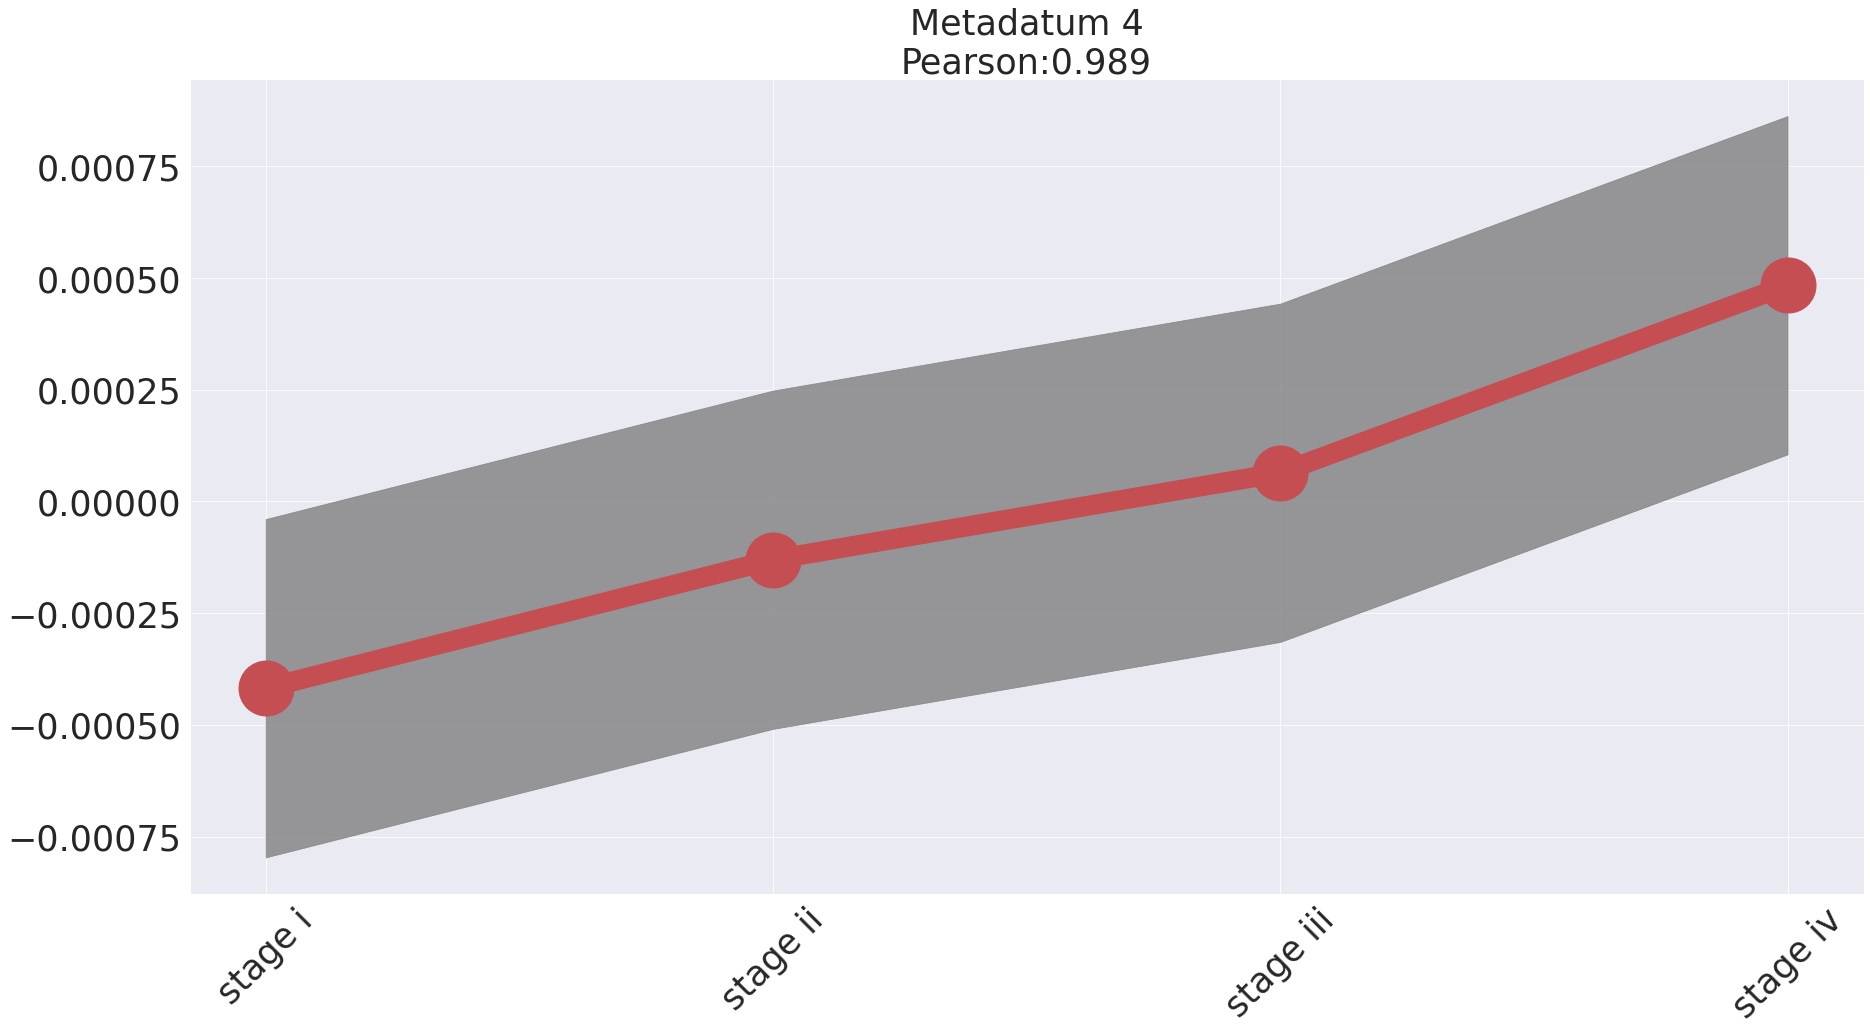

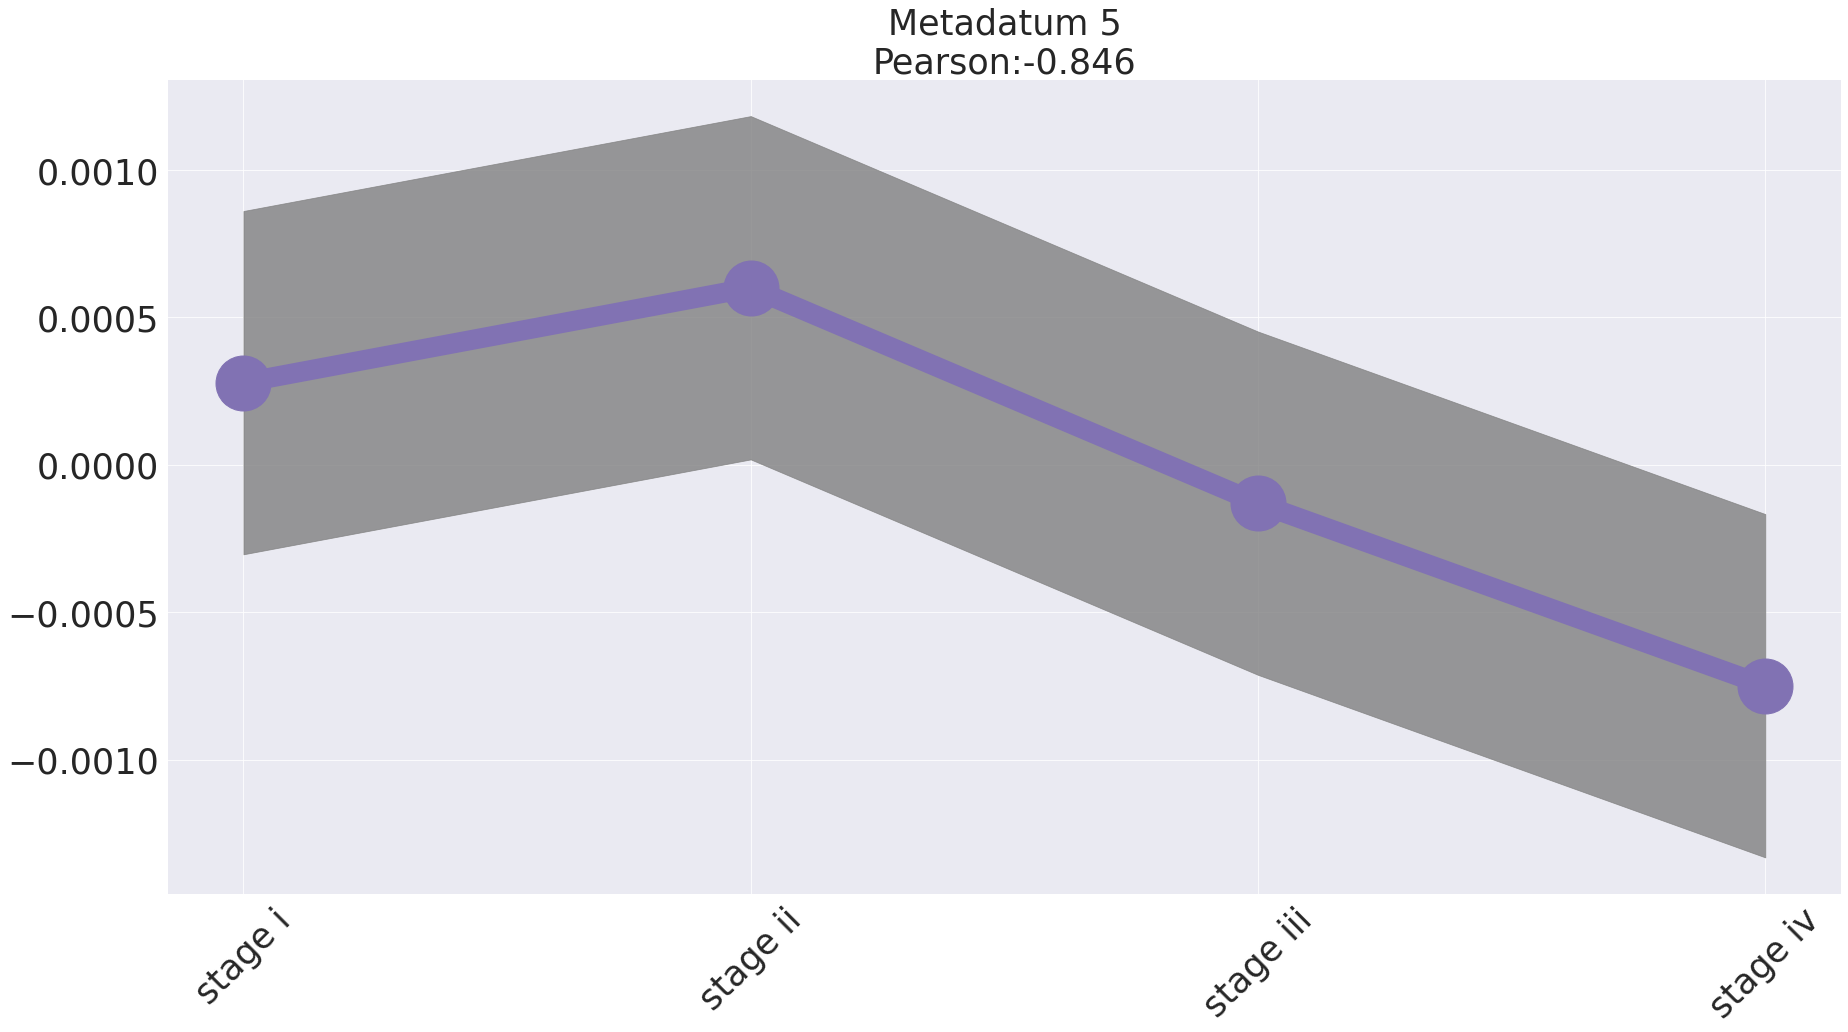

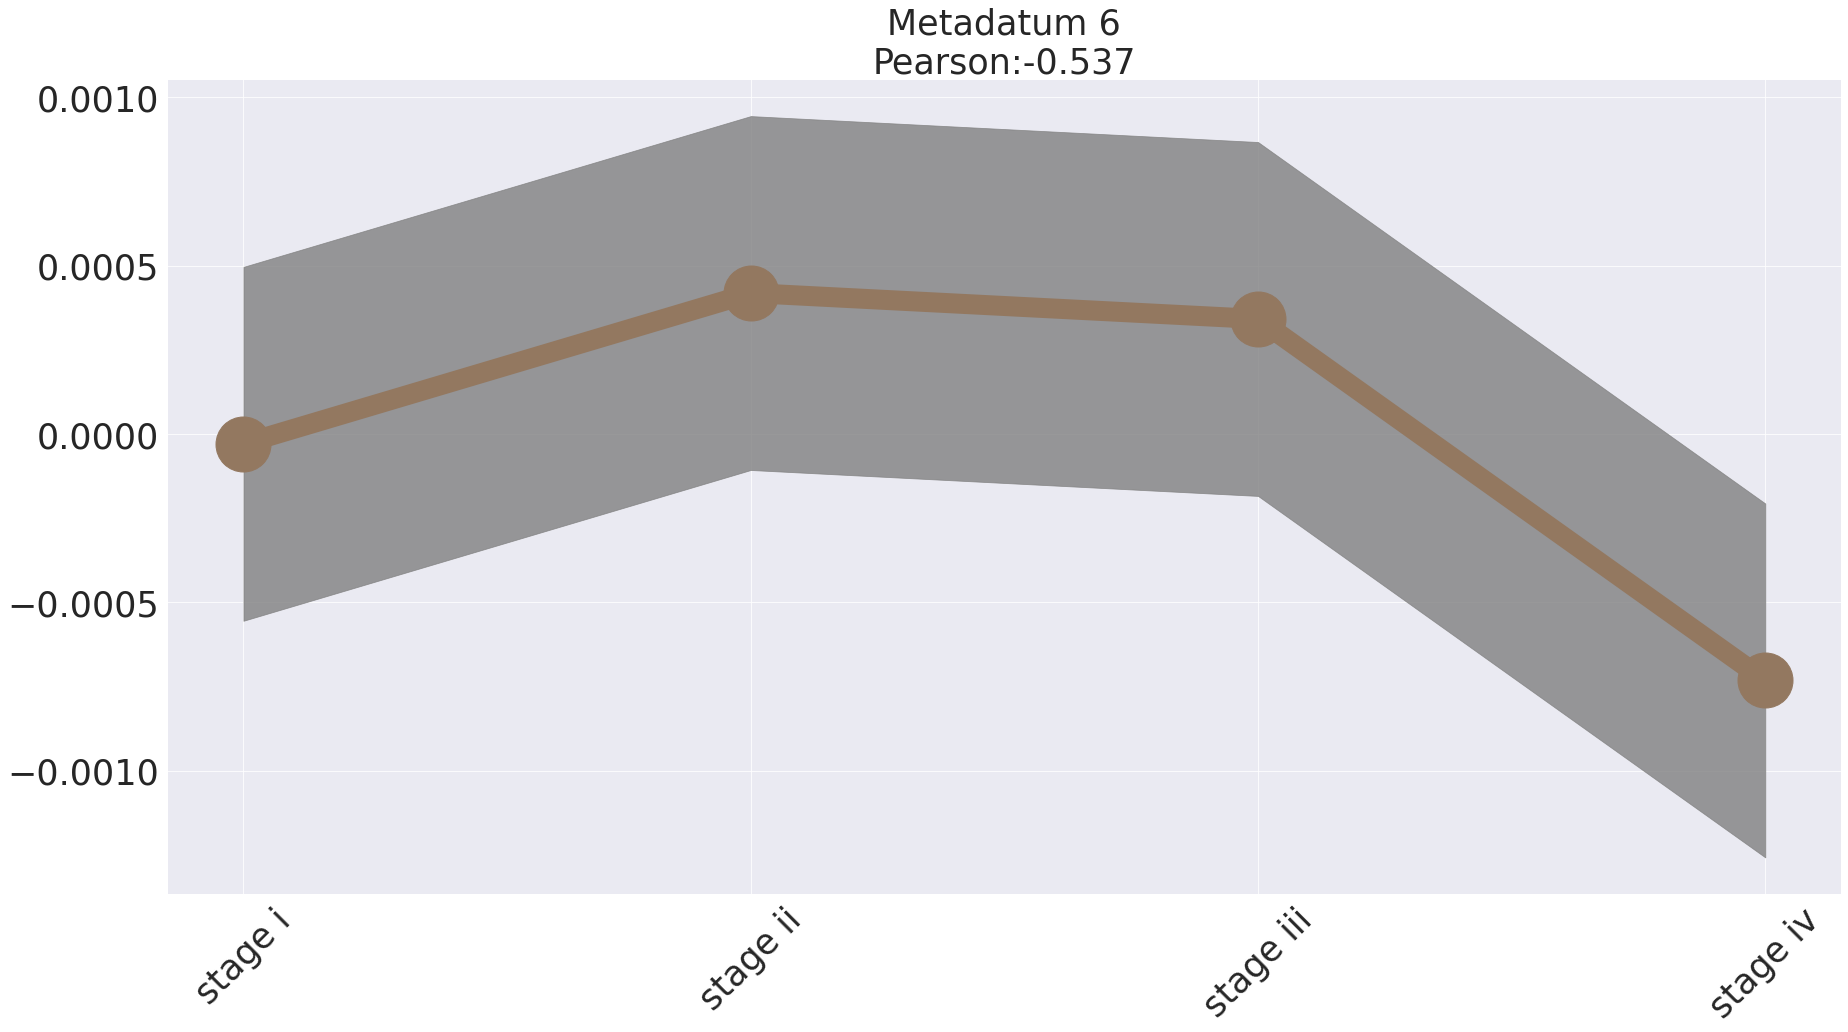

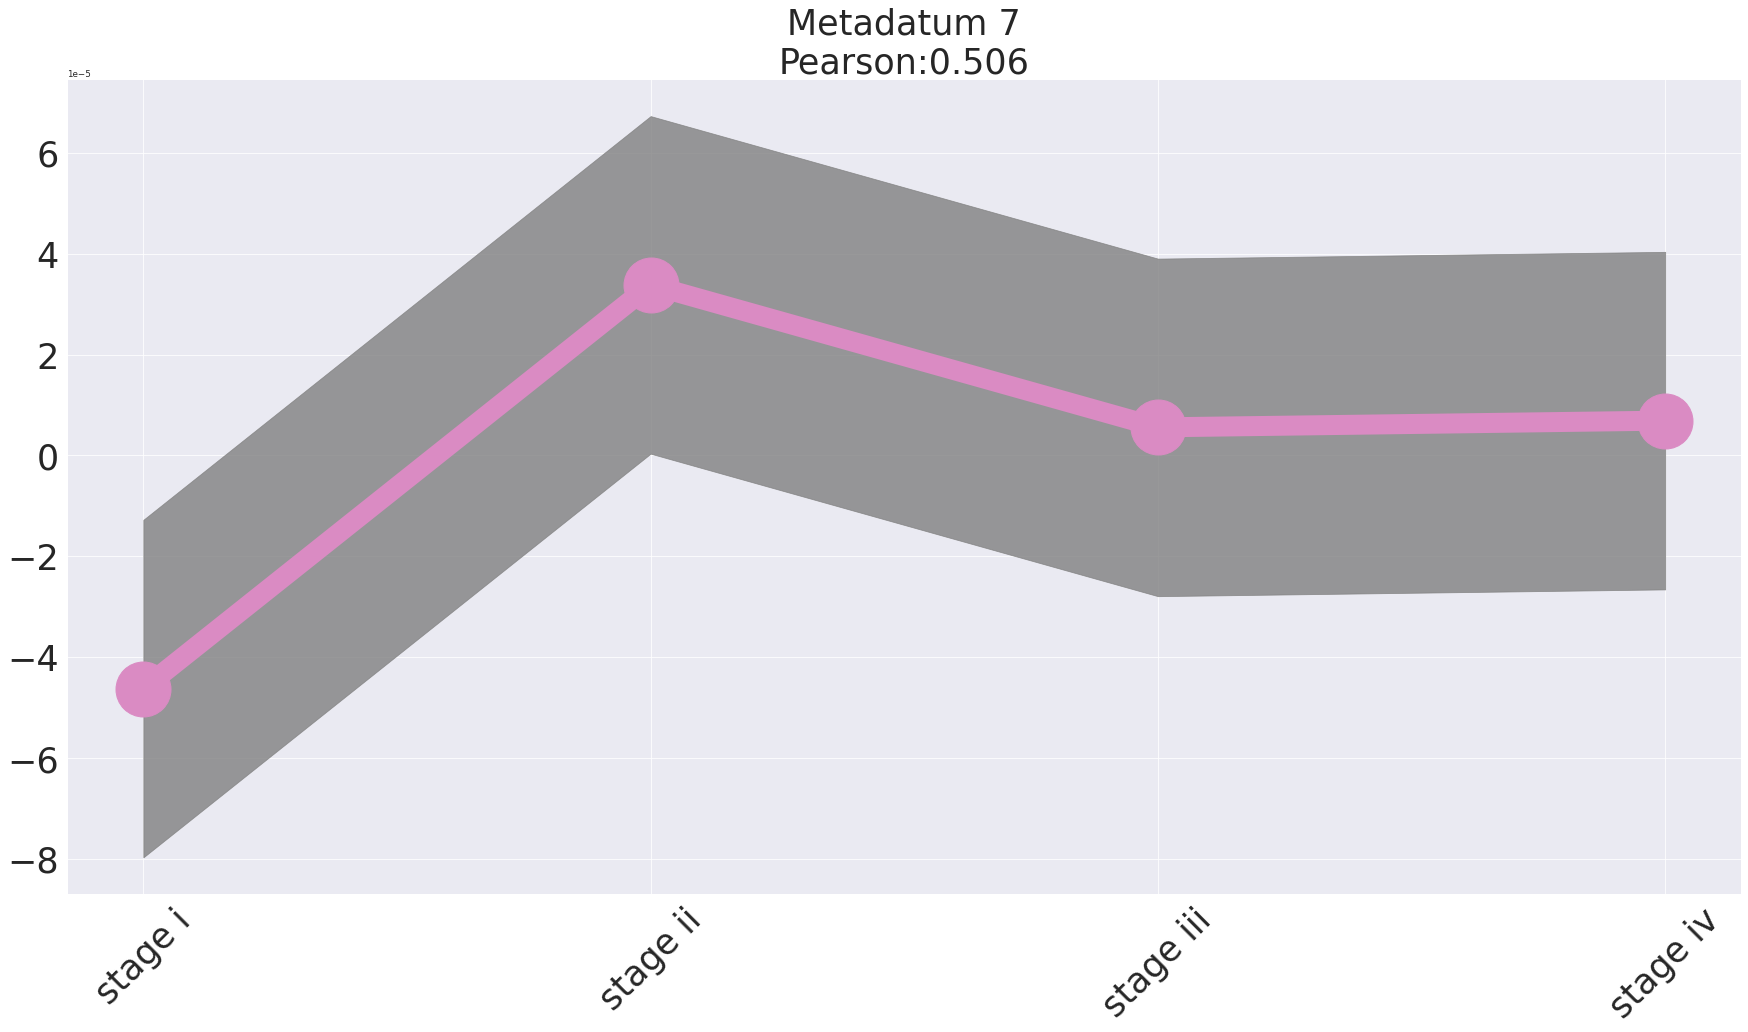

In [57]:
df_topics = pd.read_csv("%s/%s_level_%d_%s-dist.csv"%(algorithm,algorithm,l,kind[1]))

df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'stage','')
df_topics.drop('i_doc', axis=1, inplace=True)

labels=["cases.0.diagnoses.0.tumor_stage"]
label = labels[0]

if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
for sample in df_topics.index.values:
    file_data = get_file(sample,df_metadata)
    if file_data is None:
        continue
    df_topics.at[sample,'stage']=("%s"%(file_data[labels[0]]))

mask = df_topics["stage"]!="not reported"
mask = (mask) & (df_topics["stage"]!="")
mask = (mask) & (df_topics["stage"]!="stage x")
mask = (mask) & (df_topics["stage"]!="nan")
df_topic_stage_gb = df_topics[mask].groupby(["stage"]).mean()

color_generator=(c for c in sns.palettes.color_palette(n_colors=20, palette=None))



for topic in df_topic_stage_gb.columns:
    fig, ax = plt.subplots(1,1,figsize=(30,15))
    color = next(color_generator)


    df_topic_stage_dat = df_topic_stage_gb[topic]
    mean = df_topic_stage_dat.mean()
    df_topic_stage_dat=df_topic_stage_dat.subtract(mean,1)
    #sigma = df_topic_stage_dat.std(0).values[0]
    #df_topic_stage_dat=df_topic_stage_dat.divide(sigma,1)
    df_topic_stage_dat.plot(ax=ax, marker="o",ms=55, lw=20, c=color, legend=False)

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    err = df_topic_stage_dat.std()
    ax.fill_between(ax.lines[0].get_xdata(), y-err, y+err, color="gray", alpha=0.8)

    labs = np.sort(df_topics[mask]["stage"].unique())
    ax.set_xticks(x)
    ax.set_xticklabels(labels=labs, rotation=45)
    ax.tick_params(labelsize=35)
    ax.set_title(topic+"\nPearson:"+"{0:.3f}".format(pearsonr(x,y)[0]), fontsize=35)
    ax.set_xlabel("")
        
    axs[1].legend(fontsize=35, ncol=3)
    axs[0].set_ylabel("$Centered <P(%s|stage)>$"%kind[1], fontsize=35)
    fig.savefig(f"topic_{topic}.pdf")
    

    plt.show()

In [52]:
def get_cohort(subtype):
    if str(subtype)=="nan":
        return None
    else:
        if "Basal" in subtype:
            return "A"
        else:
            return "B"
df_files["cohort"]=list(map(get_cohort,df_files["Subtype_Selected"]))

450
Too low -log2(p): 0.4136993637884404
452
Too low -log2(p): 0.8865053154469135
456


/home/jovyan/work/phd/survival.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lab)


459
Too low -log2(p): 0.23530737142987943
450
Too low -log2(p): 1.0927030393440254
451
Too low -log2(p): 0.9494091819626675
180
Too low -log2(p): 1.2017536171743661


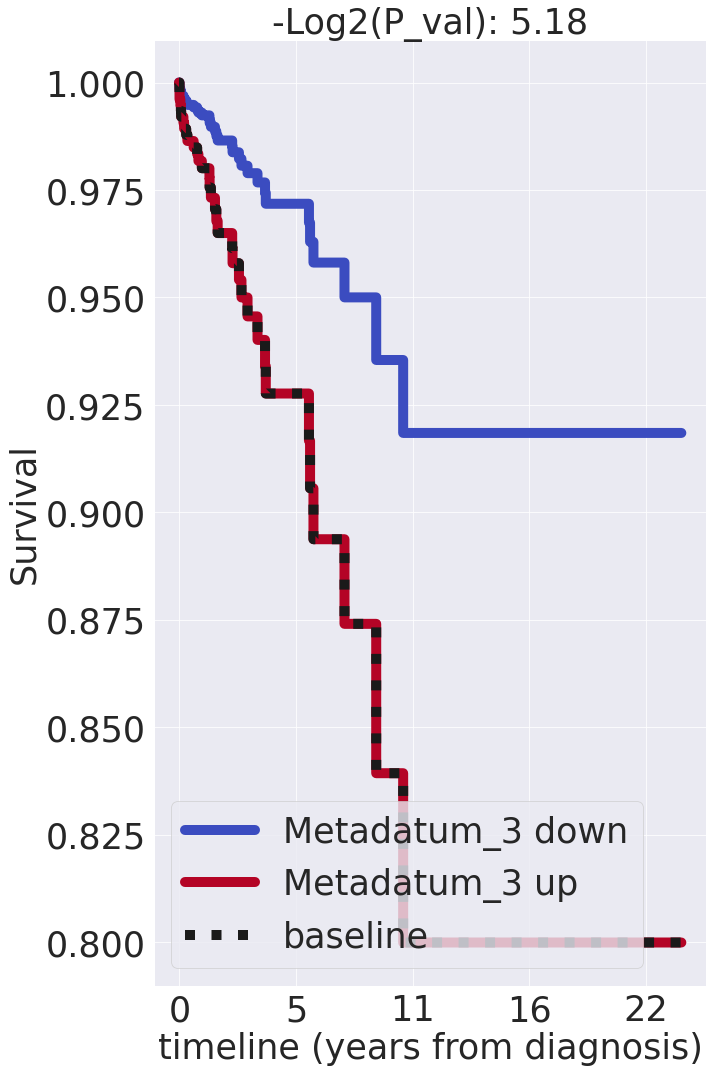

In [53]:
df_files = df_files.set_index("cases.0.submitter_id")
mask = (~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported")
subset = df_files[mask]
df_files=df_files.reset_index()
subset = subset[["days_survival","vital_status","gender", "tumor_stage", "age_at_diagnosis"]]
for topic in df_clusters.columns:
    top_set = add_group_to_subset(topic, subset, df_clusters.divide(df_clusters.sum(0),1), 0.35)
    print(top_set["group"].sum())
    summary, _, ax = fit_cox(top_set, topic)
    if summary is not None:
        if summary.at[summary.index[-1],"-log2(p)"]/(np.log2(10)) > 2:
            print(dataset,": ",topic,"\n",summary.loc[summary.index[-1],["coef", "p"]],"\n")
            ax=None
            if ax is not None:
                ax.set_title(dataset+" "+ax.title.get_text(), fontsize=35)
                save_plot(ax, dataset, topic)